<a href="https://colab.research.google.com/github/psagar2/recipes/blob/main/terapixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Performance evaluation of Terapixel rendering in Cloud (Super)computing**

## Introduction

Cloud computing is one of the most rapidly rising fields and one of the reasons for that is expensive hardware. The prime example of that is this report and the coding of this project has been done on google colab instead of existing hardware resources. So as these components are expensive to buy the rental system came into the scenario. This hardware is easily accessible to large companies with major assets to manage stuff like Google, Amazon, and Microsoft. So the upcoming new startups don't need much investment at the early stage to set up their computing infrastructure. Cloud computing has been used for many computational needs for even forming the 3-dimensional image of cities. In this project, we will be working on the dataset that was recorded of the usage of supercomputers to form a 3d image of Newcastle Upon Tyne.

This project follows the model of Crisp DM to attain the
same goal. there were certain steps taken into account those are Business understanding,
Data understanding, Data preparation, modelling, evaluation and Deployment.
Crisp Dm stands for cross industry standard for data mining. As this project follows crisp
dm process. There were 2 cycle runs and all the steps were reflected and the objectives
alignment with the data was reconsidered. As understanding of what happens and why is
it is being considered is taken into account the data understanding and preparation is well
thought and quality is hence enhanced.

## Investigating Ideology

This project will be targeted on super computing dataset. Here we are considering 3 datasets namely gpu, task and application checkpoint. Ideology behind considering this data is to know what type of computational requirements are needed to carry out future tasks, which task dominates our processing and how can the efficiency be improved. So considering this as an optimization problem this project targets to predict what and how should the planning be done for the future datasets. The best results are often obtained when the task is achieved faster. So with that ideology the stakeholders can minimize the cost of running the IAAS(infrastructure as a service).

## Business Understanding

the business objective of this project is to critically analyze how much of the computational energy is really needed and what all could be done to save time and money. As the main target is to make 3d images of the city and therefore there are terapixel Image that has to be designed. the total rendering of each pixel needs high amount of computational power. hence we set certain objectives to evaluate upon. these objectives will be discussed throughout the project.

## Data Understanding

Terapixel rendering cloud dataset has 3 comma separated files which projects the data of GPU, Pixel values, and the tasks run on them. These files consist of:

1. GPU: this has columns of timestamp,	hostname,	gpuSerial,	gpuUUID,	powerDrawWatt,	gpuTempC,	gpuUtilPerc and	gpuMemUtilPerc. These columns describe the time at which a particular gpu serial number which has a unique id uses memory and utilize gpu, while doing this what power is drawn and what temperature is achieved. this all is done on particular host provided by the hostname. There are 1024 hosts whose data is available.

2. task-x-y: this file contains columns taskId,	jobId, x,	y and	level. this data describes that a particular task is carried out at certain pixel value of an image and what is the zoom level at that point. there are 3 zoom levels considered here those are 4, 8 and 12.

3. Applictaion checkpoints: this file contains columns timestamp,	hostname,	eventName,	eventType,	jobId and taskId. these columns describe the details about the timeline of a particular event that occured on a host and there is a jobid assigned to it.

In [ ]:
pip install pandasql

In [70]:
#importing pandas to work on dataframe and reading the csv
import pandas as pd 
#pandasql is imported to use sql on dataframes
import pandasql as ps 
#matplotlib is imported to process data and plot the details
import matplotlib.pyplot as plt


In [71]:
# reading the datasets
df  = pd.read_csv('gpu.csv')
df1 = pd.read_csv('task-x-y.csv')
df2 = pd.read_csv('application-checkpoints.csv')


## Data Preprocessing

As the data contains some redundant data, data cleaning an essential part of data preprocessing which is part of Crisp-DM is required. So to take care of duplicates. Drop_duplicate function is applied to remove duplicates on the basis of all columns. 

In [ ]:
df.drop_duplicates()
df1.drop_duplicates()
df2.drop_duplicates()

For processing of data it is needed to be merged, the computational resources used by certain events and duration of that usage is needed to be calculated. ideally the data should be merged on the basis of hostname and timestamp that would return the exact values of computation for each event but as this data if inner joined on the basis of that returns 337 rows which are less than 0.01% of the data that is about 660K rows. So it is better to join on the basis of either one of the columns but as the hostname has 1024 unique values which when mapped to events return more that 150GB of data which is next to impossible to process with existing computing resources because the storage available in google colab is about 125GB and ram available is 25GB. and minimum ram ram require for merging on the basis of hostname is 80GB. Hence the timestamp was the optimum column for the join.

In [80]:
df3 = pd.merge(df, df2, on = ["timestamp"])

As the duration needs to be calculated so the data is divided on the bsais of when the task started and at what time it ended(stop). After the data is split it needs to be joined back to calculate duration of a particular event in the particular task hence the data has to be merged on the basis of task id and eventname. As the table is joined back the datatype of timestamp column of event starting and stopping is seen to be string therfore needs to be changed to date time so that duration can be calculated. It has been changed to seconds to obtain the uniform results in same scale.

In [81]:
# dividing merged data
df3start=df3[(df3['eventType']=='START')]
df3stop=df3[(df3['eventType']=='STOP')]
# merging again on the basis of task id and eventname
df3merge=pd.merge(df3start,df3stop,on=['taskId','eventName'])
# converting timestamp to date time
df3merge['timestamp_x']=pd.to_datetime(df3merge['timestamp_x'])
df3merge['timestamp_y']=pd.to_datetime(df3merge['timestamp_y'])
# calculating the duration and converting it into seconds.
df3merge['timediff']=df3merge['timestamp_y']-df3merge['timestamp_x']
df3merge['timediff']=(df3merge['timediff'].dt.total_seconds())

In [ ]:
df3merge.drop_duplicates()

To make a full dataset where even the task part can be included that is what coordinates of a pixel are using what resources for image tiles. The merged data with time duration is then again merged with task-x-y(df1) dataframe. as there are manty redundant columns so cleaning again needs to be done therfore some columns have been dropped that aren't further needed.

In [83]:
#to merge the datsets and make fully dataset that contains details of each of these 3 datframes
df4=pd.merge(df3merge,df1,on=['taskId'])

In [ ]:
df4.drop_duplicates()

In [85]:
df5=df4.drop(columns=['timestamp_x','timestamp_y','hostname_x_x','hostname_x_y','gpuSerial_y', 'gpuUUID_y', 'powerDrawWatt_y','gpuTempC_y', 'gpuUtilPerc_y', 'gpuMemUtilPerc_y','hostname_y_y', 'eventType_y', 'jobId_y', 'gpuUUID_x','jobId_x','hostname_y_x', 'gpuSerial_x','eventType_x' ])

## Methodolgy

The exploratory data analysis was started with exploration of the count of unique values of the merging columns and description of different dtaframes and knowing how many columns and how muany rows are present in each dataframe. To check the unique values nunique function is used. head function displays the top 5 rows with all the colums to give an overview of the dataframe. Describe function is used to find the numerical summary of the numerical columns in the data. 

In [86]:
df.hostname.nunique()

1024

In [87]:
df2.hostname.nunique()

1024

In [88]:
df.gpuSerial.nunique()

1024

In [89]:
df.head()

,timestamp,hostname,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc
0,2018-11-08T08:27:10.314Z,8b6a0eebc87b4cb2b0539e81075191b900001C,323217055910,GPU-1d1602dc-f615-a7c7-ab53-fb4a7a479534,131.55,48,92,53
1,2018-11-08T08:27:10.192Z,d8241877cd994572b46c861e5d144c85000000,323617020295,GPU-04a2dea7-f4f1-12d0-b94d-996446746e6f,117.03,40,92,48
2,2018-11-08T08:27:10.842Z,db871cd77a544e13bc791a64a0c8ed50000006,323217056562,GPU-f4597939-a0b4-e78a-2436-12dbab9a350f,121.64,45,91,44
3,2018-11-08T08:27:10.424Z,b9a1fa7ae2f74eb68f25f607980f97d7000010,325217085931,GPU-ad773c69-c386-a4be-b214-1ea4fc6045df,50.23,38,90,43
4,2018-11-08T08:27:10.937Z,db871cd77a544e13bc791a64a0c8ed50000003,323217056464,GPU-2d4eed64-4ca8-f12c-24bc-28f036493ea2,141.82,41,90,47


In [90]:
print(df.describe())


          gpuSerial  powerDrawWatt      gpuTempC   gpuUtilPerc  gpuMemUtilPerc
count  1.543681e+06   1.543681e+06  1.543681e+06  1.543681e+06    1.543681e+06
mean   3.239836e+11   8.919838e+01  4.007560e+01  6.305820e+01    3.341359e+01
std    1.228841e+09   3.975742e+01  3.800243e+00  4.144816e+01    2.300107e+01
min    3.201181e+11   2.255000e+01  2.600000e+01  0.000000e+00    0.000000e+00
25%    3.236170e+11   4.499000e+01  3.800000e+01  0.000000e+00    0.000000e+00
50%    3.236170e+11   9.659000e+01  4.000000e+01  8.900000e+01    4.300000e+01
75%    3.250170e+11   1.213400e+02  4.200000e+01  9.200000e+01    5.100000e+01
max    3.252171e+11   1.970100e+02  5.500000e+01  1.000000e+02    8.300000e+01


In [91]:
df1.head()

,taskId,jobId,x,y,level
0,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12
1,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12
2,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12
3,000993b6-fc88-489d-a4ca-0a44fd800bd3,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,235,11,12
4,000b158b-0ba3-4dca-bf5b-1b3bd5c28207,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,171,53,12


In [164]:
ps.sqldf('select level, count(taskId) from df1 group by level')

,level,count(taskId)
0,4,1
1,8,256
2,12,65536


In [92]:
print(df1.describe())

                  x             y         level
count  65793.000000  65793.000000  65793.000000
mean     127.031143    127.031143     11.984314
std       74.135963     74.135963      0.250965
min        0.000000      0.000000      4.000000
25%       63.000000     63.000000     12.000000
50%      127.000000    127.000000     12.000000
75%      191.000000    191.000000     12.000000
max      255.000000    255.000000     12.000000


In [93]:
df2.head()

,timestamp,hostname,eventName,eventType,jobId,taskId
0,2018-11-08T07:41:55.921Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b47f0263-ba1c-48a7-8d29-4bf021b72043
1,2018-11-08T07:42:29.842Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
2,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
3,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
4,2018-11-08T07:43:13.957Z,0d56a730076643d585f77e00d2d8521a00000N,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d


In [94]:
print(df2.describe())

                       timestamp  ...                                taskId
count                     660400  ...                                660400
unique                    363555  ...                                 65793
top     2018-11-08T07:41:31.776Z  ...  1506221a-c292-49a8-88a5-9dc1ba99b9e9
freq                          18  ...                                    20

[4 rows x 6 columns]


In [95]:
df3.head()

,timestamp,hostname_x,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,hostname_y,eventName,eventType,jobId,taskId
0,2018-11-08T08:27:10.875Z,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af
1,2018-11-08T08:27:10.875Z,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af
2,2018-11-08T08:27:10.624Z,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc
3,2018-11-08T08:27:10.624Z,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc
4,2018-11-08T08:27:10.359Z,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc


In [96]:
df3merge.head()

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff
0,2018-11-08 08:27:10.875000+00:00,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af,2018-11-08 08:27:11.996000+00:00,95b4ae6d890e4c46986d91d7ac4bf08200000T,324917052614,GPU-bc05182a-0194-740f-827e-851d9ae28136,40.97,35,0,0,265232c5f6814768aeefa66a7bec6ff6000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.121
1,2018-11-08 08:27:10.624000+00:00,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc,2018-11-08 08:27:57.365000+00:00,4c72fae95b9147189a0559269a6953ff00000P,325117172543,GPU-159afbfa-9b2e-ec8c-aff4-a920bd54b8ba,43.79,37,0,0,04dc4e9647154250beeee51b866b0715000014,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46.741
2,2018-11-08 08:27:10.359000+00:00,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000+00:00,04dc4e9647154250beeee51b866b071500001C,323617020155,GPU-51b7ec74-a5ac-06b7-1fd0-9c11ce579ffc,28.05,39,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032
3,2018-11-08 08:27:10.359000+00:00,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000+00:00,b9a1fa7ae2f74eb68f25f607980f97d7000012,325117172395,GPU-50f23433-71f3-6f16-3c86-0de884dc7493,44.21,37,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032
4,2018-11-08 08:27:10.678000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,6139a35676de44d6b61ec247f0ed865700001D,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,7e65b2da-9580-4475-8d39-7938a2975fb0,2018-11-08 08:27:58.161000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700000H,323617043161,GPU-82ba6a59-510a-9995-4167-0945785066b3,27.05,35,0,0,6139a35676de44d6b61ec247f0ed865700001D,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,47.483


In [97]:
df4.head()

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,hostname_y_x,eventName,eventType_x,jobId_x,taskId,timestamp_y,hostname_x_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,hostname_y_y,eventType_y,jobId_y,timediff,jobId,x,y,level
0,2018-11-08 08:27:10.875000+00:00,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,265232c5f6814768aeefa66a7bec6ff6000010,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,0fea60cb-e10d-4879-a50d-9c20926f50af,2018-11-08 08:27:11.996000+00:00,95b4ae6d890e4c46986d91d7ac4bf08200000T,324917052614,GPU-bc05182a-0194-740f-827e-851d9ae28136,40.97,35,0,0,265232c5f6814768aeefa66a7bec6ff6000010,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.121,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,32,174,12
1,2018-11-08 08:27:10.624000+00:00,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,04dc4e9647154250beeee51b866b0715000014,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc,2018-11-08 08:27:57.365000+00:00,4c72fae95b9147189a0559269a6953ff00000P,325117172543,GPU-159afbfa-9b2e-ec8c-aff4-a920bd54b8ba,43.79,37,0,0,04dc4e9647154250beeee51b866b0715000014,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46.741,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,167,224,12
2,2018-11-08 08:27:57.365000+00:00,4c72fae95b9147189a0559269a6953ff00000P,325117172543,GPU-159afbfa-9b2e-ec8c-aff4-a920bd54b8ba,43.79,37,0,0,04dc4e9647154250beeee51b866b0715000014,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,46496dde-fa77-4395-8cda-8705561b32dc,2018-11-08 08:27:58.370000+00:00,6139a35676de44d6b61ec247f0ed865700000P,325117063654,GPU-9abdbeab-aad4-4016-7129-099b8044c045,111.96,42,91,47,04dc4e9647154250beeee51b866b0715000014,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.005,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,167,224,12
3,2018-11-08 08:27:10.359000+00:00,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000+00:00,04dc4e9647154250beeee51b866b071500001C,323617020155,GPU-51b7ec74-a5ac-06b7-1fd0-9c11ce579ffc,28.05,39,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,248,255,12
4,2018-11-08 08:27:10.359000+00:00,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,6139a35676de44d6b61ec247f0ed8657000009,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,2018-11-08 08:27:11.391000+00:00,b9a1fa7ae2f74eb68f25f607980f97d7000012,325117172395,GPU-50f23433-71f3-6f16-3c86-0de884dc7493,44.21,37,0,0,6139a35676de44d6b61ec247f0ed8657000009,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,1.032,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,248,255,12


In [98]:
df5.head()

,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,eventName,taskId,timediff,jobId,x,y,level
0,77.87,36,90,40,Uploading,0fea60cb-e10d-4879-a50d-9c20926f50af,1.121,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,32,174,12
1,88.47,40,91,48,Render,46496dde-fa77-4395-8cda-8705561b32dc,46.741,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,167,224,12
2,43.79,37,0,0,Uploading,46496dde-fa77-4395-8cda-8705561b32dc,1.005,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,167,224,12
3,146.32,43,93,52,Uploading,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,1.032,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,248,255,12
4,146.32,43,93,52,Uploading,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,1.032,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,248,255,12


##Cycle 1:
### Objective: To find the event that dominates the task runtimes.

In [99]:
#calculating average time of each event excluding total render.
eventtime=ps.sqldf('select eventName, sum(timediff) as total_time  from df3merge  where NOT eventName="TotalRender" group by eventName')

In [100]:
eventtime

,eventName,total_time
0,Render,703087.665
1,Saving Config,43.142
2,Tiling,16727.443
3,Uploading,23927.232


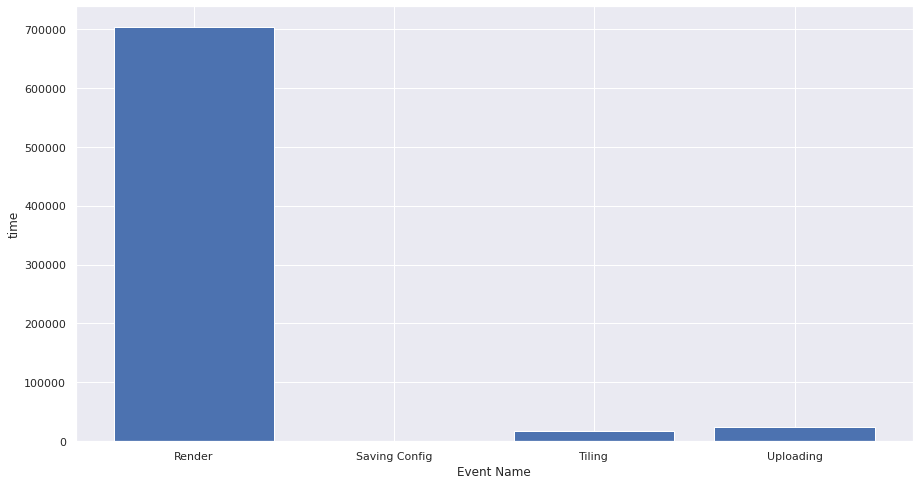

In [101]:
plt.bar(eventtime.eventName,eventtime.total_time )
plt.ylabel('time')
plt.xlabel('Event Name')
plt.rcParams['figure.figsize']=[15,8]

### Analysis and Evaluation:
Gpu execution time is majorly dominated by Render as compared to tiling and uploading. Therefore utilization of gpu should be in a way that most heavy task should be alloted the most powerfull GPU. That is render. As the most powerfull gpu will take same amount of power for processing and performance will be better as it will take less time to accomplish the task. Therefore, as the stakeholders will be able to minimize the cost, task of rendering on powerfull GPUs is recommended.

##Cycle 1:
### Objective: To know what can be predicted about GPUs performance and the actions can be taken according to that.

In [102]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

correlation between temperature and gpu utilization:
0.5059063290736544
correlation between temperature and gpu memory utilization:
0.49278284152600066
correlation between temperature and power drawn by the gpu:
0.5371909890230221


Text(0, 0.5, 'Temperature in celsius')

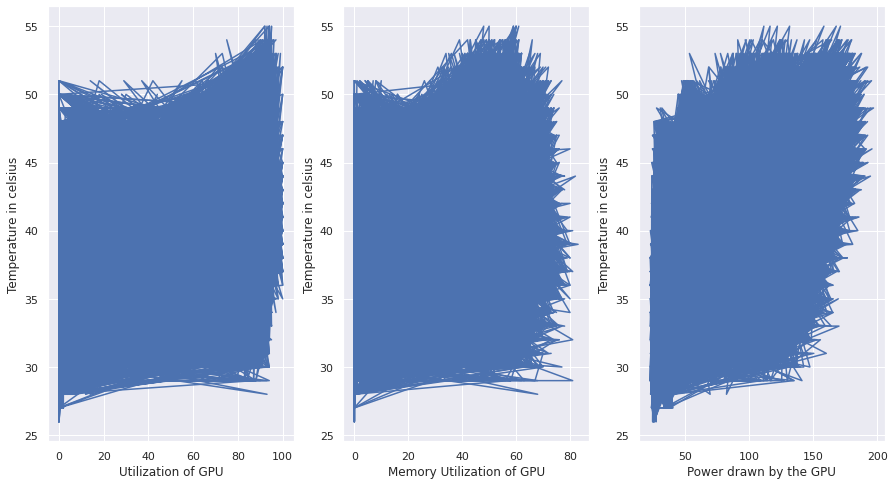

In [103]:
sns.set()
plt.subplot(1,3,1)
x=df.gpuUtilPerc
y=df.gpuTempC
print('correlation between temperature and gpu utilization:')
print(x.corr(y))
plt.plot(df.gpuUtilPerc,df.gpuTempC)
plt.xlabel("Utilization of GPU")
plt.ylabel("Temperature in celsius")

plt.subplot(1,3,2)
x=df.gpuMemUtilPerc
y=df.gpuTempC
print('correlation between temperature and gpu memory utilization:')
print(x.corr(y))
plt.plot(x,y)
plt.xlabel("Memory Utilization of GPU")
plt.ylabel("Temperature in celsius")


plt.subplot(1,3,3)
x=df.powerDrawWatt
y=df.gpuTempC
print('correlation between temperature and power drawn by the gpu:')
print(x.corr(y))
plt.plot(x,y)
plt.xlabel("Power drawn by the GPU")
plt.ylabel("Temperature in celsius")

### Analysis and Evaluation:
As it can be observed that correlation between temperature and utilization is about 0.5 and the graph depicts that high temperatures are achieved even when the gpu performence is low. Hence there is no direct relation between these.
Similarly for memory utilization the correlation is 0.49 and power draw it is 0.53. Therfore they are not corelated however visually it seems partially related as there is a slight corelation but not so strong to make a business decision on it. 
**Moreover the cooling system is suggested to be used at all times and there running cost should be considered as an important cost compounding factor.**

corelation between memory utilization and power drawn
0.8707451224651878
corelation between GPU utilization and power drawn
0.8626730321864096


Text(0, 0.5, 'Power drawn by the GPU')

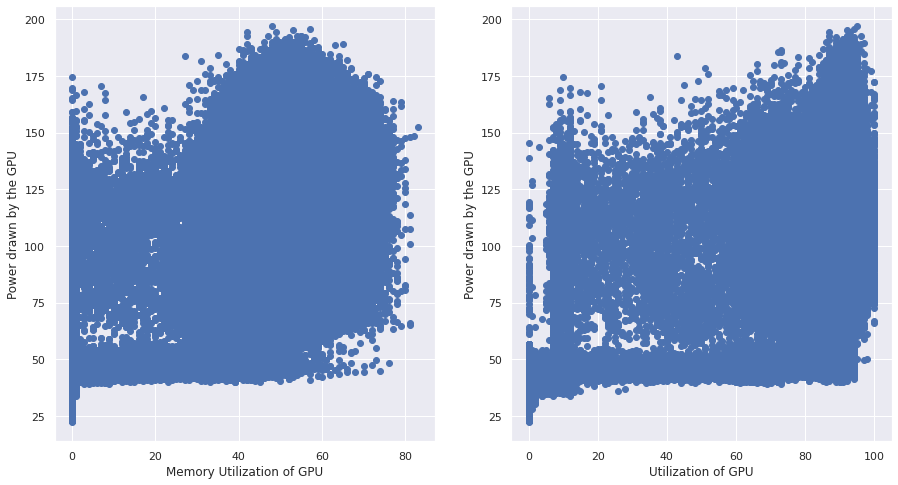

In [104]:
plt.subplot(1,2,1)
x=df.gpuMemUtilPerc
y=df.powerDrawWatt
print('corelation between memory utilization and power drawn')
print(x.corr(y))
plt.scatter(x,y)
plt.xlabel("Memory Utilization of GPU")
plt.ylabel("Power drawn by the GPU")

plt.subplot(1,2,2)
x=df.gpuUtilPerc
y=df.powerDrawWatt
print('corelation between GPU utilization and power drawn')
print(x.corr(y))
plt.scatter(x,y)
plt.xlabel("Utilization of GPU")
plt.ylabel("Power drawn by the GPU")

### Analysis and Evaluation:
The graph and the correlation value suggests strong dependency of power drawn with gpu and memory utilization. These suggest that all the heavy task should be planned at such durations where power is easily available so that system failure chances of the cloud provided are less. Running out of resources is a major problem when using cloud's services. so task scheduling will become better.

0.9665710683356831


Text(0, 0.5, 'Memory utilization of GPU')

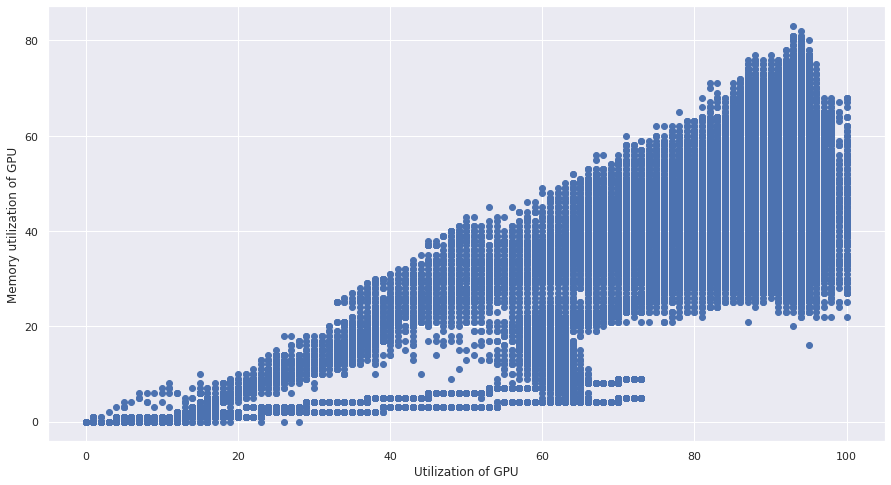

In [105]:
x=df.gpuUtilPerc
y=df.gpuMemUtilPerc
print(x.corr(y))
plt.scatter(x,y)
plt.xlabel("Utilization of GPU")
plt.ylabel("Memory utilization of GPU")

### Analysis and Evaluation:
Memory and GPU utilization show almost linear relationship with clear correlation of 0.96. Therfore gpu shpould be chosen accordingly that they can run task with maximum usage at a time. For example as render is a computationally expensive task so it should be given a heavier gpu which can be fully utilized and erest of the tasks can be clubbed and be done on weaker GPU. 

##Cycle 2:
### Objective: GPUs performance of particular events related to time taken for its completion.

In [110]:
dfrender=ps.sqldf('select  timestamp_x,	hostname_x_x,	gpuSerial_x,	gpuUUID_x,	powerDrawWatt_x,	gpuTempC_x,	gpuUtilPerc_x	,gpuMemUtilPerc_x, eventName,timediff from df3merge where eventName="Render" ')
dfrender.head()

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,eventName,timediff
0,2018-11-08 08:27:10.624000,b9a1fa7ae2f74eb68f25f607980f97d700000B,324917052053,GPU-cd9e7193-8237-4e36-aa41-f5e30f10044a,88.47,40,91,48,Render,46.741
1,2018-11-08 08:27:10.678000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,Render,47.483
2,2018-11-08 08:27:10.678000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,Render,47.483
3,2018-11-08 08:27:10.678000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,Render,47.483
4,2018-11-08 08:27:10.678000,83ea61ac1ef54f27a3bf7bd0f41ecaa700000T,323617021291,GPU-fa23937e-9287-a4f8-f648-3787bfa31054,71.59,41,89,42,Render,47.483


In [111]:
correlation_matrix=dfrender.corr()
round(correlation_matrix,2)

,gpuSerial_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,timediff
gpuSerial_x,1.00,-0.01,-0.16,-0.01,-0.01,-0.01
powerDrawWatt_x,-0.01,1.00,0.50,0.85,0.87,0.01
gpuTempC_x,-0.16,0.50,1.00,0.46,0.45,0.04
gpuUtilPerc_x,-0.01,0.85,0.46,1.00,0.97,0.02
gpuMemUtilPerc_x,-0.01,0.87,0.45,0.97,1.00,0.02
timediff,-0.01,0.01,0.04,0.02,0.02,1.00


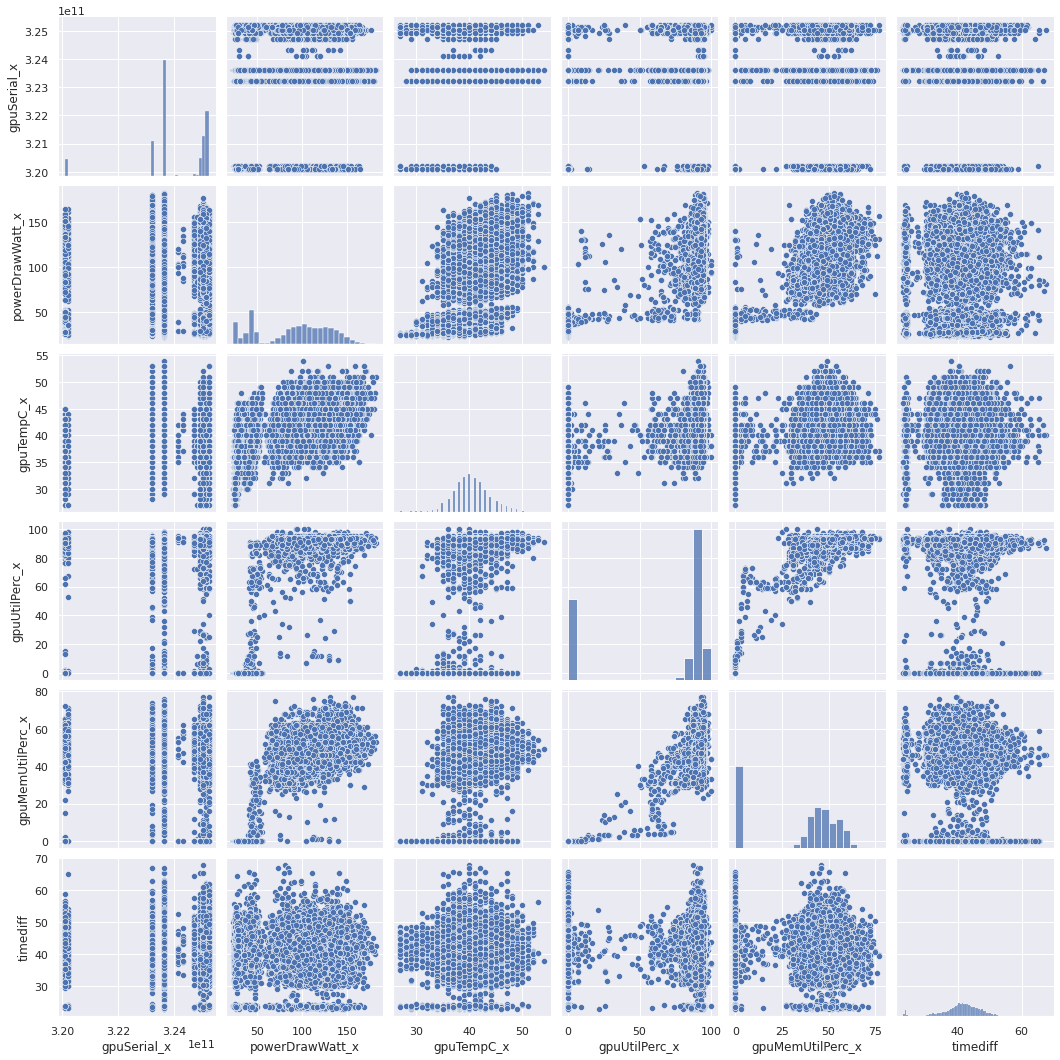

In [112]:
sns.pairplot(dfrender)

In [113]:
dfrender1=ps.sqldf('select avg(powerDrawWatt_x),	avg(gpuTempC_x), avg(gpuUtilPerc_x),	avg(gpuMemUtilPerc_x),avg(timediff) from dfrender group by eventName')
dfrender1

,avg(powerDrawWatt_x),avg(gpuTempC_x),avg(gpuUtilPerc_x),avg(gpuMemUtilPerc_x),avg(timediff)
0,91.307876,40.326308,64.990254,34.497505,41.27797


Render exactly represents the whole data, it can be observed the duration and gpu utilization is divided into 2 parts. that clearly shows there are 2 types of gpu one aren't performing at alla nd are taking a lot of time for even simple tasks and on the other side there can be seen that majorly powerfull gpus are working for lesser time to do the same task with full utilization but certain gpu are not that capable and even when used for the their full potential takes time to accomplish the same task. also it can be observed the temperature is partially dependent on redering task. 

In [114]:
dfsavingconfig=ps.sqldf('select timestamp_x,	hostname_x_x,	gpuSerial_x,	gpuUUID_x,	powerDrawWatt_x,	gpuTempC_x,	gpuUtilPerc_x	,gpuMemUtilPerc_x, eventName,timediff from df3merge where eventName="Saving Config" ')
dfsavingconfig.head()

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,eventName,timediff
0,2018-11-08 08:27:10.574000,a77ef58b13ad4c01b769dac8409af3f800000Y,323617020164,GPU-d480204b-d0c9-1631-fd55-7ae42e6470cf,141.29,41,94,58,Saving Config,0.003
1,2018-11-08 08:27:13.460000,265232c5f6814768aeefa66a7bec6ff600000S,323617043068,GPU-976b3bbd-fdea-ee53-615f-a98f28408299,125.99,44,94,53,Saving Config,0.002
2,2018-11-08 08:27:13.460000,0745914f4de046078517041d70b22fe700000E,325017017790,GPU-769c04e0-4916-d031-0e0c-7d13fdde3e3d,39.31,35,0,0,Saving Config,0.002
3,2018-11-08 08:27:13.460000,6139a35676de44d6b61ec247f0ed8657000019,320218055685,GPU-c5b20fb1-a8a2-3699-9def-2db4f6b0abc6,110.95,42,89,49,Saving Config,0.002
4,2018-11-08 08:27:13.460000,95b4ae6d890e4c46986d91d7ac4bf08200000S,325217085955,GPU-019fdcd4-8840-a5d2-9bce-7e19077e0f6c,88.22,40,93,54,Saving Config,0.002


In [115]:
correlation_matrix=dfsavingconfig.corr()
round(correlation_matrix,2)

,gpuSerial_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,timediff
gpuSerial_x,1.00,-0.02,-0.17,-0.01,-0.00,-0.00
powerDrawWatt_x,-0.02,1.00,0.49,0.85,0.86,0.00
gpuTempC_x,-0.17,0.49,1.00,0.45,0.44,0.01
gpuUtilPerc_x,-0.01,0.85,0.45,1.00,0.96,-0.00
gpuMemUtilPerc_x,-0.00,0.86,0.44,0.96,1.00,-0.00
timediff,-0.00,0.00,0.01,-0.00,-0.00,1.00


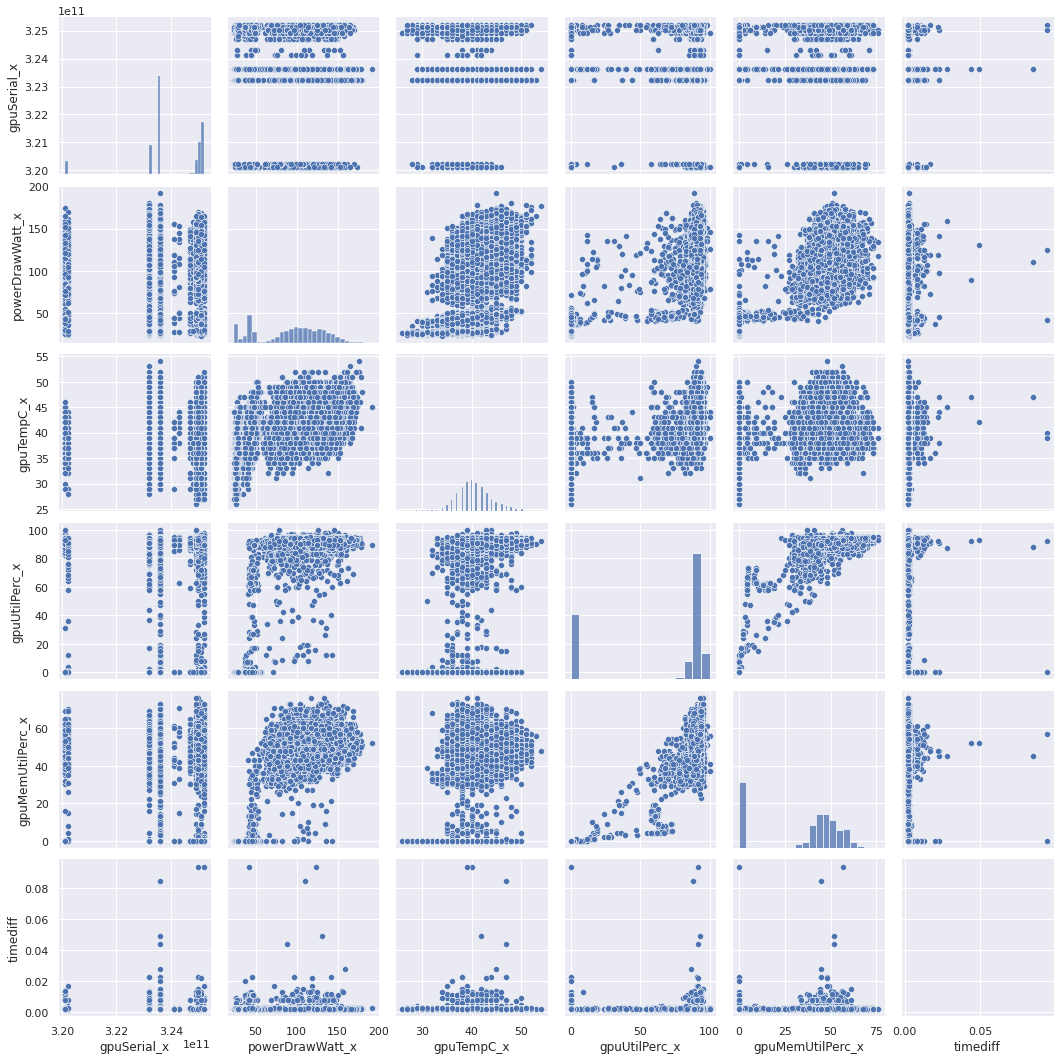

In [116]:
sns.pairplot(dfsavingconfig)

In [117]:
dfsavingconfig1=ps.sqldf('select avg(powerDrawWatt_x),	avg(gpuTempC_x), avg(gpuUtilPerc_x),	avg(gpuMemUtilPerc_x)	 from dfsavingconfig')
dfsavingconfig1

,avg(powerDrawWatt_x),avg(gpuTempC_x),avg(gpuUtilPerc_x),avg(gpuMemUtilPerc_x)
0,91.828857,40.41882,65.67448,34.963526


## Analysis and evaluation:
it can be clearly observed saving config event has no dependency on time difference so it requires the least time and  any change in it's computational resources does not affect the time. so it can be alloteed to the weak GPu to accomplish many tasks at the same time.

In [166]:
dftiling=ps.sqldf('select timestamp_x,	hostname_x_x,	gpuSerial_x,	gpuUUID_x,	powerDrawWatt_x,	gpuTempC_x,	gpuUtilPerc_x	,gpuMemUtilPerc_x, eventName,timediff from df3merge where eventName="Tiling" ')
dftiling.head()

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,eventName,timediff
0,2018-11-08 08:27:07.855000,5903af3699134795af7eafc605ae5fc7000014,325017020245,GPU-a7e39f02-521d-647e-a02e-64b49a138e50,49.81,40,0,0,Tiling,1.046
1,2018-11-08 08:27:07.855000,5903af3699134795af7eafc605ae5fc7000014,325017020245,GPU-a7e39f02-521d-647e-a02e-64b49a138e50,49.81,40,0,0,Tiling,1.046
2,2018-11-08 08:27:07.855000,0d56a730076643d585f77e00d2d8521a00000B,325017017512,GPU-971d7d26-9fb1-ab60-5180-75d82081d8cf,122.79,37,91,45,Tiling,1.046
3,2018-11-08 08:27:07.855000,0d56a730076643d585f77e00d2d8521a00000B,325017017512,GPU-971d7d26-9fb1-ab60-5180-75d82081d8cf,122.79,37,91,45,Tiling,1.046
4,2018-11-08 08:27:13.845000,83ea61ac1ef54f27a3bf7bd0f41ecaa7000018,323617021519,GPU-0d5cec28-4daf-bab0-b4e8-2e53a81b48b1,97.67,43,92,46,Tiling,1.125


In [167]:
correlation_matrix=dftiling.corr()
round(correlation_matrix,2)

,gpuSerial_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,timediff
gpuSerial_x,1.00,-0.01,-0.16,0.01,0.01,-0.01
powerDrawWatt_x,-0.01,1.00,0.48,0.85,0.86,0.00
gpuTempC_x,-0.16,0.48,1.00,0.45,0.43,0.03
gpuUtilPerc_x,0.01,0.85,0.45,1.00,0.96,0.00
gpuMemUtilPerc_x,0.01,0.86,0.43,0.96,1.00,0.01
timediff,-0.01,0.00,0.03,0.00,0.01,1.00


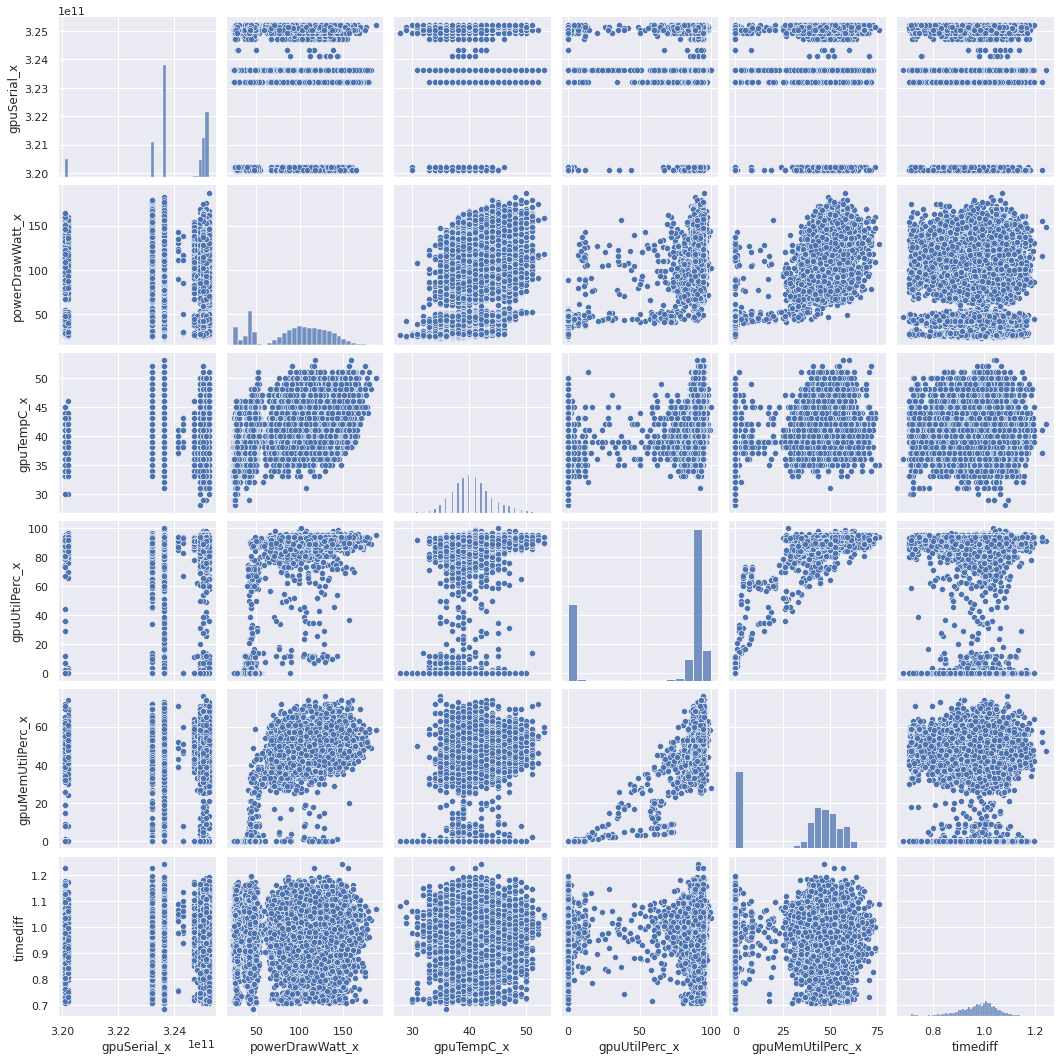

In [145]:
sns.pairplot(dftiling)

In [147]:
dftiling1=ps.sqldf('select avg(powerDrawWatt_x),	avg(gpuTempC_x), avg(gpuUtilPerc_x),	avg(gpuMemUtilPerc_x)	 from dftiling group by eventName')
dftiling1

,avg(powerDrawWatt_x),avg(gpuTempC_x),avg(gpuUtilPerc_x),avg(gpuMemUtilPerc_x)
0,92.071739,40.531967,65.994177,34.988995


For tiling it is observed it is takes time randomly with many computational requirements. So it can be take into account that this event can be task specific that means that it can require different Gpu configurations depending on the pixel coordinates. Therefore tiling can be more dependent on task rather than computational power so gpu optimization here is not possible.

In [149]:
dfuploading=ps.sqldf('select timestamp_x,	hostname_x_x,	gpuSerial_x,	gpuUUID_x,	powerDrawWatt_x,	gpuTempC_x,	gpuUtilPerc_x	,gpuMemUtilPerc_x, eventName,timediff from df3merge where eventName="Uploading" ')
dfuploading.head()

,timestamp_x,hostname_x_x,gpuSerial_x,gpuUUID_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,eventName,timediff
0,2018-11-08 08:27:10.875000,4a79b6d2616049edbf06c6aa58ab426a000008,325017019905,GPU-0e6e345c-ba46-d455-b6a1-ba8a2cfc62c0,77.87,36,90,40,Uploading,1.121
1,2018-11-08 08:27:10.359000,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,Uploading,1.032
2,2018-11-08 08:27:10.359000,4c72fae95b9147189a0559269a6953ff00000X,325117063055,GPU-21dc01c9-a613-e5ed-d2f9-e4320a7517e3,146.32,43,93,52,Uploading,1.032
3,2018-11-08 08:27:15.057000,dcc19f48bb3445a28338db3a8f002e9c00000Y,323617020762,GPU-48504260-2b36-e796-830a-8dc7b9ab851a,102.97,42,89,42,Uploading,0.920
4,2018-11-08 08:27:15.883000,4c72fae95b9147189a0559269a6953ff00000V,325017049278,GPU-0c038861-d224-604e-f31b-e6b0fef9b6f3,106.59,42,90,44,Uploading,0.939


In [150]:
correlation_matrix=dfuploading.corr()
round(correlation_matrix,2)

,gpuSerial_x,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,timediff
gpuSerial_x,1.00,-0.04,-0.18,-0.02,-0.02,0.00
powerDrawWatt_x,-0.04,1.00,0.48,0.85,0.85,-0.07
gpuTempC_x,-0.18,0.48,1.00,0.45,0.44,-0.14
gpuUtilPerc_x,-0.02,0.85,0.45,1.00,0.96,-0.05
gpuMemUtilPerc_x,-0.02,0.85,0.44,0.96,1.00,-0.05
timediff,0.00,-0.07,-0.14,-0.05,-0.05,1.00


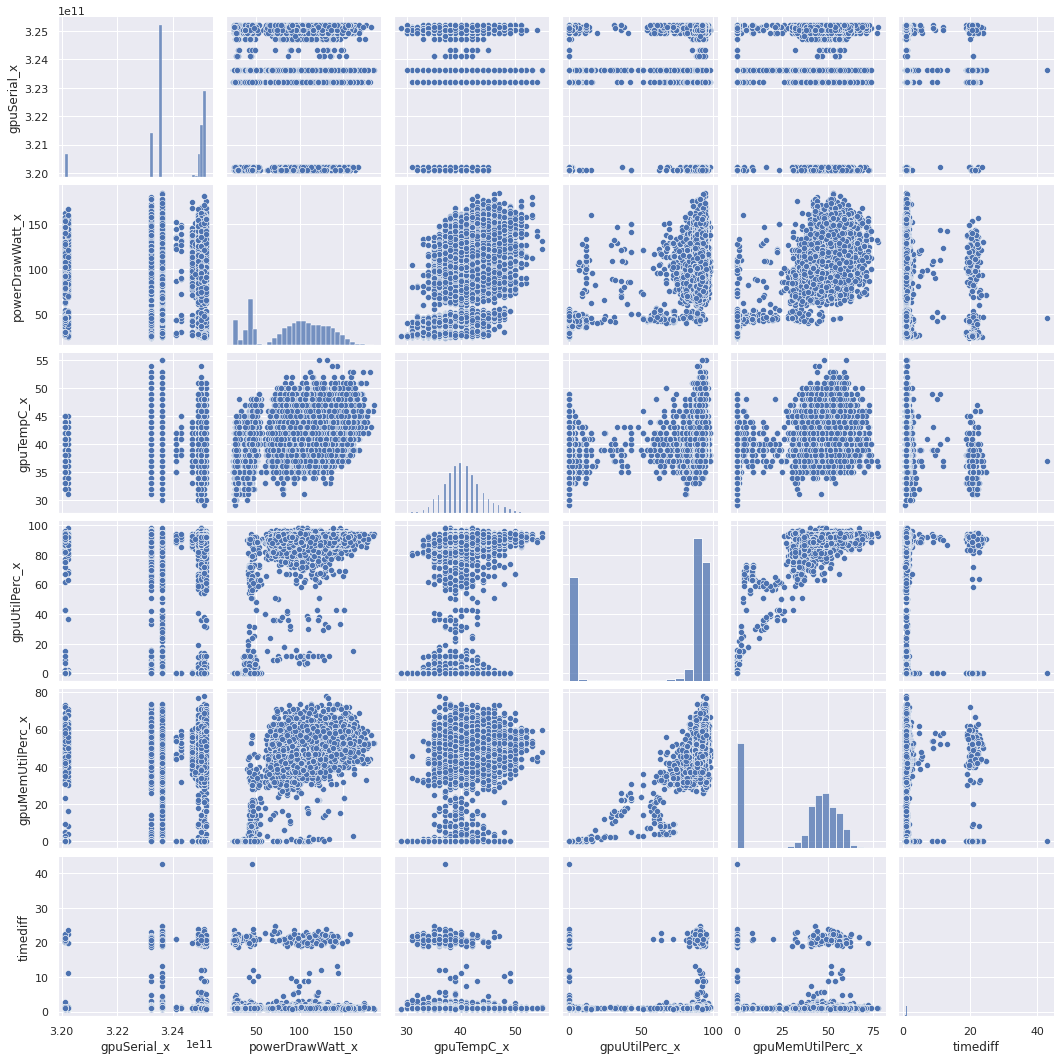

In [151]:
sns.pairplot(dfuploading)

In [152]:
dfuploading1=ps.sqldf('select avg(powerDrawWatt_x),	avg(gpuTempC_x), avg(gpuUtilPerc_x),	avg(gpuMemUtilPerc_x)	 from dfuploading group by eventName')
dfuploading1

,avg(powerDrawWatt_x),avg(gpuTempC_x),avg(gpuUtilPerc_x),avg(gpuMemUtilPerc_x)
0,91.572035,40.449708,65.517413,34.740807


### Analysis and Evaluation
For uploading it can be seen that the computation requirements doesn't change it's time for uploading. therfore it can be scheduled in those time when gpu will be needed for other events after this. So, for this all the gpu can run parallely and this event could be completed fast so that for other events gpu is available.

## Cycle 2:
### Objective: The best and the worst performing GPU.
### Analysis and Evaluation:
In this project the performance has been calculated as per average Gpu utilization per unit average time. this has been taken into account as gpu utilization is directly dependent on memory and power, also it is partially dependent on temperature. So being close to check the thermal design power, that is one of the most important factor of calculating gpu performance. In this project a small unit is taken because of the lack of computational resources and time limit.  The project only considers the total event so that it can return an unbiased value that is **Total Render**.  

In [132]:
dfgpu= ps.sqldf('select gpuSerial_x ,avg(timediff) as average_time, avg(gpuUtilPerc_x) as average_utilization from df3merge  where eventName="TotalRender" group by gpuSerial_x')
dfgpu['average_performance']=dfgpu['average_utilization']/dfgpu['average_time']
dfgpu=ps.sqldf('select * from dfgpu order by average_performance')
dfgpu

,gpuSerial_x,average_time,average_utilization,average_performance
0,323617021537,46.448353,20.882353,0.449582
1,323617021323,36.365667,18.533333,0.509638
2,323617020887,44.364900,26.700000,0.601827
3,323617043132,48.658238,29.428571,0.604801
4,323617020087,36.809625,22.750000,0.618045
...,...,...,...,...
1019,323617042614,37.939286,86.285714,2.274310
1020,323217056299,35.101818,82.818182,2.359370
1021,320118119725,38.729636,92.272727,2.382484
1022,320118118790,38.541444,92.444444,2.398572


In [133]:
dfgpu1= ps.sqldf('select * from dfgpu where average_performance<=1')

In [134]:
dfgpu1

,gpuSerial_x,average_time,average_utilization,average_performance
0,323617021537,46.448353,20.882353,0.449582
1,323617021323,36.365667,18.533333,0.509638
2,323617020887,44.364900,26.700000,0.601827
3,323617043132,48.658238,29.428571,0.604801
4,323617020087,36.809625,22.750000,0.618045
5,323617020264,41.101222,25.444444,0.619068
6,323617021475,41.200600,29.533333,0.716818
7,325217084598,43.027750,32.937500,0.765494
8,325017020198,41.925500,33.000000,0.787110
9,323217056304,41.969688,33.375000,0.795217


So after calculating  the measure only less than 1 was considered because they represent the least performing GPU. As the average performance of these is close to 0. These are the serial number of worst performing cards.  

## Cycle 2:
### Objective: How are image coordinates related to computational power.

In [135]:
df5=ps.sqldf('select * from df5 where eventName="TotalRender"')

In [136]:
df5.drop_duplicates()

,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,eventName,taskId,timediff,jobId,x,y,level
0,119.85,38,92,52,TotalRender,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,44.736,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,248,255,12
2,105.08,40,91,44,TotalRender,723b6fff-9d27-4b67-8b9d-ae40a501b1bc,44.736,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,248,255,12
4,124.88,43,93,52,TotalRender,59f756d6-2e27-4c33-b44e-28aac785da46,42.430,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,186,14,12
5,140.29,41,89,46,TotalRender,59f756d6-2e27-4c33-b44e-28aac785da46,42.430,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,186,14,12
6,90.95,45,92,44,TotalRender,da7fc9b5-d485-42eb-8207-1ed95d9545f3,47.729,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,107,95,12
...,...,...,...,...,...,...,...,...,...,...,...
17470,27.47,38,0,0,TotalRender,995d840e-6fc8-437f-992a-020d27fa3a78,49.570,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,188,163,12
17472,137.46,40,94,57,TotalRender,c01ab173-2b8a-4c80-9dff-eaf470a5cd68,41.535,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,17,127,12
17473,79.00,36,92,57,TotalRender,b000c9e1-ebc6-4276-a0dc-85b31beb434b,38.632,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,43,193,12
17474,47.60,41,0,0,TotalRender,436cce16-2783-477c-996f-068a3ba2b129,37.713,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,93,230,12


Text(0, 0.5, 'y coordinate')

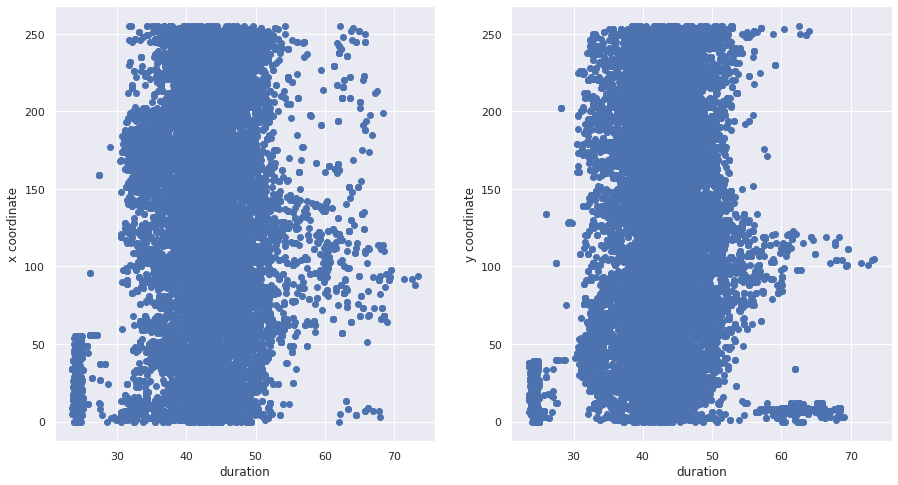

In [173]:
x=df5.x
y=df5.y

plt.subplot(1,2,1)
plt.scatter(df5.timediff,x)
plt.xlabel('duration')
plt.ylabel('x coordinate')
plt.subplot(1,2,2)
plt.scatter(df5.timediff,y)
plt.xlabel('duration')
plt.ylabel('y coordinate')

Text(0, 0.5, 'y coordinate')

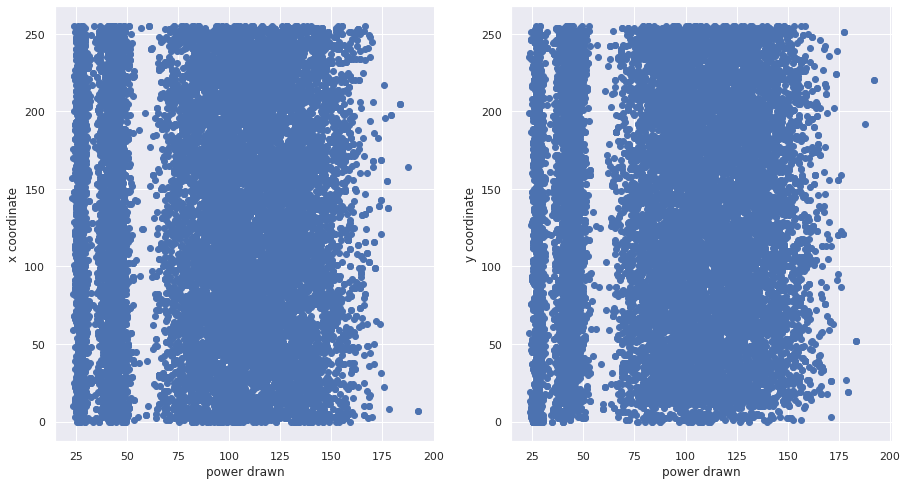

In [174]:
x=df5.x
y=df5.y

plt.subplot(1,2,1)
plt.scatter(df5.powerDrawWatt_x,x)
plt.xlabel('power drawn')
plt.ylabel('x coordinate')
plt.subplot(1,2,2)
plt.scatter(df5.powerDrawWatt_x,y)
plt.xlabel('power drawn')
plt.ylabel('y coordinate')

Text(0, 0.5, 'y coordinate')

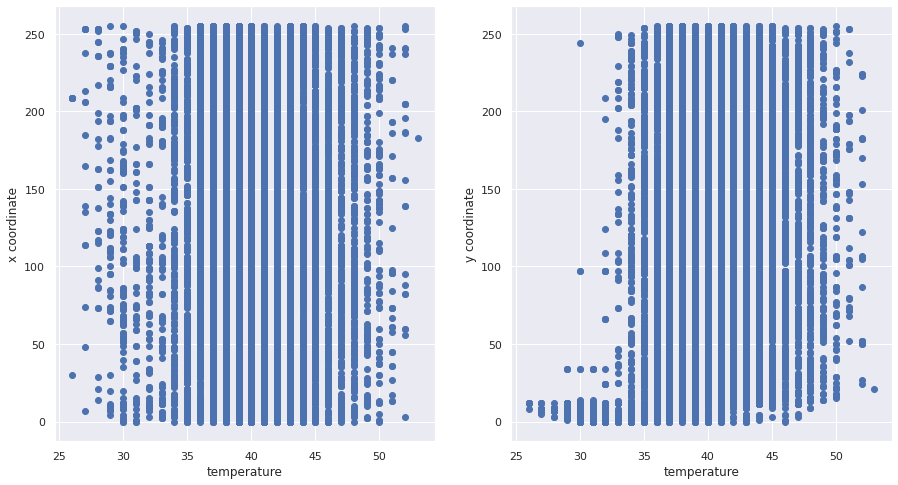

In [170]:
x=df5.x
y=df5.y

plt.subplot(1,2,1)
plt.scatter(df5.gpuTempC_x,x)
plt.xlabel('temperature')
plt.ylabel('x coordinate')
plt.subplot(1,2,2)
plt.scatter(df5.gpuTempC_x,y)
plt.xlabel('temperature')
plt.ylabel('y coordinate')

Text(0, 0.5, 'y coordinate')

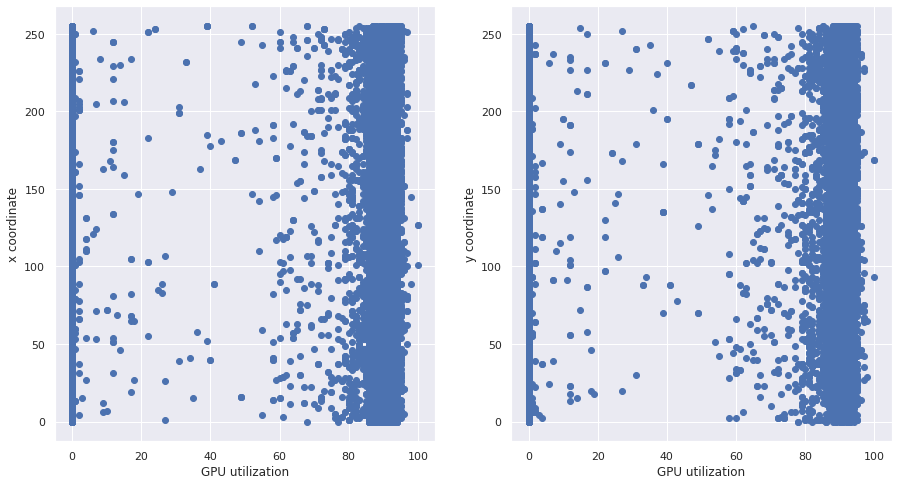

In [172]:
x=df5.x
y=df5.y

plt.subplot(1,2,1)
plt.scatter(df5.gpuUtilPerc_x,x)
plt.xlabel('GPU utilization')
plt.ylabel('x coordinate')
plt.subplot(1,2,2)
plt.scatter(df5.gpuUtilPerc_x,y)
plt.xlabel('GPU utilization')
plt.ylabel('y coordinate')

Text(0, 0.5, 'y coordinate')

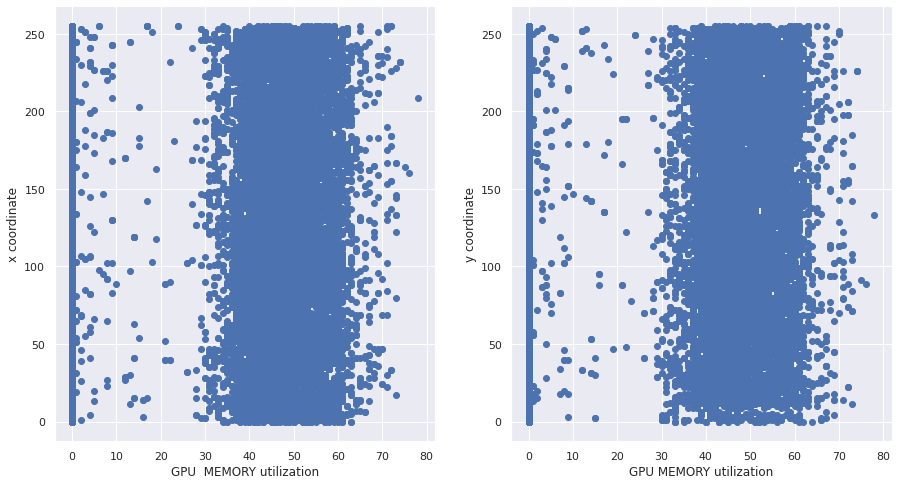

In [171]:
x=df5.x
y=df5.y

plt.subplot(1,2,1)
plt.scatter(df5.gpuMemUtilPerc_x,x)
plt.xlabel('GPU  MEMORY utilization')
plt.ylabel('x coordinate')
plt.subplot(1,2,2)
plt.scatter(df5.gpuMemUtilPerc_x,y)
plt.xlabel('GPU MEMORY utilization')
plt.ylabel('y coordinate')

In [142]:
correlation_matrix=df5.corr()
round(correlation_matrix,2)

,powerDrawWatt_x,gpuTempC_x,gpuUtilPerc_x,gpuMemUtilPerc_x,timediff,x,y,level
powerDrawWatt_x,1.00,0.50,0.85,0.86,-0.04,0.01,0.08,0.03
gpuTempC_x,0.50,1.00,0.47,0.45,-0.06,0.03,0.16,0.09
gpuUtilPerc_x,0.85,0.47,1.00,0.96,-0.04,0.01,0.08,0.03
gpuMemUtilPerc_x,0.86,0.45,0.96,1.00,-0.03,0.01,0.08,0.02
timediff,-0.04,-0.06,-0.04,-0.03,1.00,0.11,0.11,-0.05
x,0.01,0.03,0.01,0.01,0.11,1.00,0.00,0.10
y,0.08,0.16,0.08,0.08,0.11,0.00,1.00,0.10
level,0.03,0.09,0.03,0.02,-0.05,0.10,0.10,1.00


## Analysis and Evaluation:
Pixel coordinates are not responsible for anycomputational requirements so it can be concluded that they are independent. hence all the coordinates use similar compuutational resources. therefore computational resources only depend on events not the pixel coordinates. Also the change in city or the place to apply 3d image rendering has no affect on computational requirements but only the size of city would increase the time these will be used. 

# Result and Conclusion:
After carefull examination and exploratory data analysis. Using CRISPDM methodolgy. the business perspective was quite clear for consideartion and reflective practice allowed this project to get better results and exploration of many minute details. Some conclusions drawn here are:
1. Event Render dominates the task runtime, so faster gpu can be alloted for this event. to achieve more in  less time.
2. Temperature is partially dependent so it is recommended to have cooling system full time. It will compound the cost majorly. So the rented server should be near to poles. So that thermal cost isn't high.
3. Memory, power and gpu utilization are depndent on each other so running out of resources and execution failing can be a possibility.
4. saving config and uploading are least time taking events so they can be run parallely and their execution can be planned accordingly.
5. The worst perfroming GPU have been listed so that next time these GPU and their serial numbers can be avoided.
6. Image coordinates have no effect on computational power so the model is easily scalable for any other cities.
